#Hippocampal Neural Decoder


This project uses machine learning methods to create a neural decoder. A neural decoder is a model that has the ability to predict what stimiulus evoked some neural response. Neural decoders are useful in brain-computer interfaces (BCI) as the software that drives the transformation of a user's neural input into the BCI into intention to affect the environemnt. This project is guided by Kording Lab's paper on [Machine Learning for Neural Decoding](https://www.eneuro.org/content/7/4/ENEURO.0506-19.2020).


In [ ]:
import math
import sys

import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing

##Data Pipeline for Neural Decoding

I was going to use this dataset:
[Decoding Hippocampal Place Cell Data
](https://cbmm.mit.edu/learning-hub/tools-datasets/decoding-hippocampal-place-cell-data); however, I could not find the annotations or documentation on the structure of the data. To me I could not reason about the meaning of the data tables. Here is an [article](http://cs.wellesley.edu/~cs125/reading/advanced_medicine_prize_2014.pdf) on hippocampal place cells included with this dataset; it may proviede useful background information.

Instead, I will use the rat hippocampal, multi-unit recording, open field foraging dataset found [here](https://crcns.org/data-sets/hc/hc-2). Specifically, I will be using the dataset with ID "ec014.333".

An example of data extraction can be found [here](https://github.com/KordingLab/Neural_Decoding/blob/master/Examples_hippocampus/Example_format_data_hc.ipynb). The dataset's official documentation can be found [here](https://crcns.org/data-sets/hc/hc-2/about-hc-2).

###hc2 Dataset Description

3 male Long-Evans rats were implanted with a 4-shank or 8-shank silicon probe in layer CA1 of the right dorsal hippocampus. Each shank had 8 recording sites. The rat IDs of these 3 rats are ec13, ec14, and ec16. Each rat weighed in between 250 and 400 grams.

![CA1ImageURL](https://www.researchgate.net/profile/Vz-Marmarelis/publication/7518796/figure/fig2/AS:341443152498691@1458417799545/a-Diagrammatic-representation-of-the-rat-brain-a1-showing-the-relative-location-of.png "the CA1 region of the rat hippocampus")

[paper source](https://www.researchgate.net/publication/7518796_Restoring_lost_cognitive_function)

If I am interested in exploring the 3D structure of various animal brains, I can visit [EBrains' Atlases](https://ebrains.eu/services/atlases#services)


###Data Collection

In [ ]:
#@title Import the hc2 Dataset
from scipy.io import loadmat
folder = ""
data = loadmat(folder+"hc_data_raw.mat")

In [ ]:
#@title Extracting Training Examples from the Imported hc2 .mat Dataset
print(f"The type of the data after being imported with scipy.io.loadmat():\n\t{type(data)}")
print(f"Keys of the dictionary data object:\n\t{data.keys()}\n")

# access spike times for all neurons
spike_times = data['spike_times']
print(f"Type of data['spike_times']:\n\t{type(spike_times)}")
print(f"Shape of the np.ndarray at data['spike_times']:\n\t{spike_times.shape}")
print("The np.ndarray at data['spike_times'] is a column vector.")
print(f"dtype of data['spike_times']:\n\t{spike_times.dtype}")
print(f"Type of data['spike_times'][0, 0]:\n\t{type(spike_times[0, 0])}")
print(f"Shape of the np.ndarray at data['spike_times'][0, 0]:\n\t{spike_times[0, 0].shape}")
print(f"dtype of data['spike_times'][0, 0]:\n\t{spike_times[0, 0].dtype}")
print(f"Shape of the np.ndarray at data['spike_times'][56, 0]:\n\t{spike_times[56, 0].shape}\n")
print("""The shapes of each of the np.ndarrays of spike_times vary significantly 
across the 58 elements of data['spike_times']. Each of these 58 elements 
represents a different recording site across the 8 shanks (in the case of 
dataset ec014.333). This is less than the expected number of recording sites 
according to the dataset documentation which states that there should be 64 
channels; however, it is also stated that the number of channels may not be a 
multiple of 8 because "bad" channels were removed from the data.
Also, note that the varying lengths of the ndarrays of spike_times indicates that
this spike_times is a jagged array.""")

# access the  x and y positions
pos = data['pos']
print(f"Type of data['pos']:\n\t{type(pos)}")
print(f"Shape of data['pos']:\n\t{pos.shape}")
print(f"dtype of data['pos']:\n\t{pos.dtype}\n")

# load times at which positions were recorded
pos_times = data['pos_times'][0]
print(f"Type of data['pos_times']:\n\t{type(data['pos_times'])}")
print(f"Shape of the np.ndarray at data['pos_times']:\n\t{data['pos_times'].shape}")
print(f"Type of data['pos_times'][0]:\n\t{type(pos_times)}")
print(f"Shape of the np.ndarray at data['pos_times'][0]:\n\t{pos_times.shape}")

The type of the data after being imported with scipy.io.loadmat():
	<class 'dict'>
Keys of the dictionary data object:
	dict_keys(['__header__', '__version__', '__globals__', 'spike_times', 'pos_times', 'pos'])

Type of data['spike_times']:
	<class 'numpy.ndarray'>
Shape of the np.ndarray at data['spike_times']:
	(58, 1)
The np.ndarray at data['spike_times'] is a column vector.
dtype of data['spike_times']:
	object
Type of data['spike_times'][0, 0]:
	<class 'numpy.ndarray'>
Shape of the np.ndarray at data['spike_times'][0, 0]:
	(112, 1)
dtype of data['spike_times'][0, 0]:
	float64
Shape of the np.ndarray at data['spike_times'][56, 0]:
	(105868, 1)

The shapes of each of the np.ndarrays of spike_times vary significantly 
across the 58 elements of data['spike_times']. Each of these 58 elements 
represents a different recording site across the 8 shanks (in the case of 
dataset ec014.333). This is less than the expected number of recording sites 
according to the dataset documentation whic

###Data Preprocessing

In [ ]:
# @title Data Preprocessing Hyperparameters
bin_size = 0.2 # seconds
# spike_pruning_threshold = 100
# spike_pruning_threshold = 500
spike_pruning_threshold = 1000
# spike_pruning_threshold = 10000
normalization = "standardization"
pre_bins = 5
present_bin = True
post_bins = 3
# at every infernce, the model will take in as input 
# (num_bins_per_recording_site_per_example * num_recording_sites) number of 
# independent variables. in other words, this number is the length of a 
# single training example vector.
num_bins_per_recording_site_per_example = pre_bins + present_bin + post_bins
# i will not be creating a validation set, since I will be using cross-
# validation on the training dataset to validate my models (model selection and
# hyperparameter tuning).
precent_training_data = 0.8
# one problem that is specific to time series analysis where the examples are
# ranges of time series data and come from the same experiment is that during
# random sampling time bins from overlapping rangs that were randomly sampled
# into different datasets will actually share features.
# i theorize that this will not be too problematic since even though they share
# values, these values will appear in different locations in the feature vector.
# compounded with how the shared value will be obfuscated by the non-shared 
# values, these examples are actually almost entirely different. this data 
# leakage will likely have an overall low impact on the sanctity of the 
# generalization performance reported on the test dataset, but this 
# consideration is listed here because i have not formally proved the 
# negligibility of this data leakage. thus, i have included it here as a 
# hyperparameter so that the impact of this data leakage can be investigated
# statistically.
randomly_sample_train_test_datasets = False

hyperparameters = {
    "bin_size": 0.2, # seconds
    "spike_pruning_threshold": 100,
    "normalization": "standardization",
    "pre_bins": 5,
    "present_bin": True,
    "post_bins": 3,
    "num_bins_per_recording_site_per_example": pre_bins + present_bin + post_bins,
    "precent_training_data": 0.8,
    "randomly_sample_train_test_datasets": False
}

In [ ]:
# @title Clean Data
print(f"The number of position (x,y) pairs in the dataset:\n\t{len(pos)}\n")

isnan_pos = np.isnan(pos)
print(f"Number of elements of the x-y position np.ndarray that are NaN:\n\t{np.sum(isnan_pos)}")
print(f"Number of elements of the x-y position np.ndarray that are NOT NaN:\n\t{np.sum(~isnan_pos)}\n")
err_msg: str = f"""The NaN and non-NaN values do not partition the dataset. The 
actual sum of NaN and non-NaN values was {np.sum(isnan_pos) + np.sum(~isnan_pos)} 
when it was expected to be {len(pos) * 2}."""
assert np.sum(isnan_pos) + np.sum(~isnan_pos) == len(pos) * 2, err_msg

# locate position pairs where either x or y positions are NaN
# np.nonzero() returns a tuple of np.ndarrays each array is rank-1 and is of the
# same size. in order to get the index tuple for a single element where the
# value is non-zero, you need to index into every array in the tuple with the 
# same index.
# the size of the tuple is equal to the rank of the input np.ndarray
nan_pos_idxs = np.asarray(
    np.isnan(pos[:, 0]) | np.isnan(pos[:, 1])
).nonzero()[0]
print(f"Number of position pairs of the x-y position np.ndarray that are NaN:\n\t{len(nan_pos_idxs)}")
print(f"Indices of position pairs of the x-y position np.ndarray that are NaN:\n\t{nan_pos_idxs}\n")

cleaned_pos_data = np.delete(
    pos, nan_pos_idxs, axis=0
)

cleaned_pos_times_data = np.delete(
    pos_times, nan_pos_idxs, axis=0
)

print(f"Shape of np.ndarray containing the cleaned position data:\n\t{cleaned_pos_data.shape}")
print(f"Shape of np.ndarray containing the time stamps of the cleaned position data:\n\t{cleaned_pos_times_data.shape}")

assert ~np.isnan(cleaned_pos_data).any(), "A NaN value was found in the pos_data np.ndarray after cleaning."
assert ~np.isnan(cleaned_pos_times_data).any(), "A NaN value was found in the pos_times_data np.ndarray after cleaning."

t_start = cleaned_pos_times_data[0]
t_final = cleaned_pos_times_data[-1]
print(f"Time of the starting sample in the cleaned position data:\n\t{t_start}")
print(f"Time of the final sample in the cleaned position data:\n\t{t_final}")

# find where continguous blocks of NaN values start and end.
nan_pos_idxs_diff = nan_pos_idxs - np.insert(nan_pos_idxs, 0, nan_pos_idxs[0]  - 1)[:-1]
non1_diffs_idxs = np.asarray(nan_pos_idxs_diff != 1).nonzero()[0]
print(f"Discrete difference of indices of NaN values in the position array that did not have a value of 1:\n\t{non1_diffs_idxs}")
print("""There was only a single pair of indices in the sorted ndarray of NaN 
indices in the position np.ndarray that did not have a difference that was not 
1. This means that the positions were not recorded in consecutive position
samples in 2 contiguous blocks: one block at the beginning of the position
samples array and another at th end of the position samples array. This is 
particularly nice for our training examples since when the NaN values are 
pruned, the model would expect that the time bins are continuous and are in the
same form as the samples at inference time.\n""")

print(f"Shape of np.ndarray spike_times before squeezing:\n\t{spike_times.shape}")
# remove the extra axis wrapped around the 
spike_times = np.squeeze(spike_times)
print(f"Shape of np.ndarray spike_times after squeezing:\n\t{spike_times.shape}\n")

# every ndarray of the ndarray spike_times need to be iteratively squeezed since
# numpy does not support broadcasting with jagged ndarrays like spike_times.
# must specify the dtype as 'object' if i am intentionally trying to make a 
# jagged array (which is a deprecated feature of numpy).
spike_times = np.asarray([np.squeeze(st) for st in spike_times], dtype='object')

# since the spike_times ndarray is a jagged array achieved by making an ndarray 
# of ndarrays (this may seem silly since ndarrays of ndarrays can be reduced to
# a single ndarray; however, in order to perform this reduction the inner 
# ndarrays must all be of the same length, as this is a requirement for all
# np.ndarrays). therefore, clearning must be performed iteratively without 
# relying on broadcasting.
cleaned_spike_times = np.asarray(
    [arr[(arr >= t_start) & (arr <= t_final)] for arr in spike_times],
    dtype='object'
)

print(f"First 5 spike times of 2nd to last recording site pre-clean:\n\t{spike_times[-2][:5]}")
print(f"First 5 spike times of 2nd to last recording site post-clean:\n\t{cleaned_spike_times[-2][:5]}")
print(f"Last 5 spike times of 2nd to last recording site pre-clean:\n\t{spike_times[-2][-5:]}")
print(f"Last 5 spike times of 2nd to last recording site post-clean:\n\t{cleaned_spike_times[-2][-5:]}")

The number of position (x,y) pairs in the dataset:
	219089

Number of elements of the x-y position np.ndarray that are NaN:
	2980
Number of elements of the x-y position np.ndarray that are NOT NaN:
	435198

Number of position pairs of the x-y position np.ndarray that are NaN:
	1490
Indices of position pairs of the x-y position np.ndarray that are NaN:
	[     0      1      2 ... 219086 219087 219088]

Shape of np.ndarray containing the cleaned position data:
	(217599, 2)
Shape of np.ndarray containing the time stamps of the cleaned position data:
	(217599,)
Time of the starting sample in the cleaned position data:
	27.419354838709676
Time of the final sample in the cleaned position data:
	5598.284690220174
Discrete difference of indices of NaN values in the position array that did not have a value of 1:
	[1070]
There was only a single pair of indices in the sorted ndarray of NaN 
indices in the position np.ndarray that did not have a difference that was not 
1. This means that the posit

In [ ]:
# @title Bin and Prune Spike Train Data

# (recording site, time bin)
# when indexing into spike_trains, you cannot use you cannot use 
# spike_times[n, -1] because spike_trains is really a 1-D np.ndarray of lists, 
# not a 2-D np.ndarray
binned_spike_data = np.zeros(
    (len(spike_times), math.ceil((t_final - t_start) / bin_size))
)
for rs in range(len(cleaned_spike_times)):
    for t in cleaned_spike_times[rs]:
        binned_spike_data[rs][math.floor((t - t_start) / bin_size)] += 1

# prune out recording sites that have low responsiveness. this is useful because
# these features have demonstrated to be unresponsive to any variation in the 
# moouse's position. in other words, these features are uninformative.
spike_sum_per_recording_site = np.nansum(binned_spike_data, axis=1)
print(f"Shape of the np.ndarray containing the per recording site spike sum:\n\t{spike_sum_per_recording_site.shape}")
print(f"The np.ndarray containing the per recording site spike sum:\n\t{spike_sum_per_recording_site}\n")

unresponsive_recording_sites = np.where(
    spike_sum_per_recording_site < spike_pruning_threshold
)[0]
print(f"Number of insufficiently responsive recording sites:\n\t{len(unresponsive_recording_sites)}")
print(f"Indices of the insufficiently responsive recording sites:\n\t{unresponsive_recording_sites}\n")

# remove the unresponsive recording sites (a.k.a. uninformative features) from 
# the spiking data.
pruned_binned_cleaned_spike_data = np.delete(
    binned_spike_data, unresponsive_recording_sites, axis=0
)
print(f"Shape of the np.ndarray containing the pruned spiking data:\n\t{pruned_binned_cleaned_spike_data.shape}")

Shape of the np.ndarray containing the per recording site spike sum:
	(58,)
The np.ndarray containing the per recording site spike sum:
	[1.07000e+02 3.00000e+00 1.57000e+02 3.00000e+00 1.50000e+01 4.20000e+01
 5.09000e+02 1.00000e+01 1.26000e+02 2.00000e+01 4.98000e+02 3.90000e+01
 1.30000e+01 1.05000e+02 6.71000e+02 2.45800e+03 2.40000e+01 1.53000e+02
 5.55000e+02 2.40000e+01 2.00400e+03 1.56400e+03 5.80000e+01 1.01000e+02
 1.74600e+03 1.58600e+03 1.68200e+03 5.19200e+03 4.89000e+02 1.12800e+03
 3.81000e+02 8.09000e+02 8.23000e+02 3.76700e+03 5.88940e+04 1.25500e+03
 2.59900e+03 5.93900e+03 1.02000e+03 3.60000e+02 7.77300e+03 5.94200e+03
 1.93000e+02 5.24000e+02 9.30000e+01 3.09900e+03 2.70700e+03 2.07900e+03
 8.17000e+02 1.39900e+03 2.05100e+03 9.88380e+04 1.85000e+02 5.86900e+03
 1.19700e+03 8.81770e+04 1.04856e+05 7.23000e+02]

Number of insufficiently responsive recording sites:
	32
Indices of the insufficiently responsive recording sites:
	[ 0  1  2  3  4  5  6  7  8  9 10 11 12

In [ ]:
# @title Bin Position Data
# bin position data
# (neuron, time bin)
# compute the average of the output/labeled data that fall into the same time
# bin.
binned_cleaned_pos_data = np.zeros((math.ceil((t_final - t_start) / bin_size), 2))
bin_n = 0
# curr_bin = math.floor(t_start / bin_size)
curr_bin = 0
for idx, t in enumerate(cleaned_pos_times_data):
    calc_bin = math.floor((t - t_start) / bin_size)
    if calc_bin != curr_bin:
        if bin_n:
            binned_cleaned_pos_data[curr_bin] /= bin_n
        else:
            print(f"There were no positions recorded for bin index {curr_bin}")
        bin_n = 0
        curr_bin = calc_bin
    binned_cleaned_pos_data[calc_bin] += cleaned_pos_data[idx]
    bin_n += 1

# handle the final bin separately since the threshold to the next bin will
# never be crossed in the above for-loop for the bin corresponding to the final
# position recording.
if bin_n:
    binned_cleaned_pos_data[curr_bin] /= bin_n
else:
    print(f"There were no positions recorded for bin index {curr_bin}")

print(f"Shape of the np.ndarray containing the clean position data:\n\t{cleaned_pos_data.shape}")
print(f"Shape of the np.ndarray containing the binned, clean position data:\n\t{binned_cleaned_pos_data.shape}")

Shape of the np.ndarray containing the clean position data:
	(217599, 2)
Shape of the np.ndarray containing the binned, clean position data:
	(27855, 2)


Shape of the pruned and binned spike train data:
	(26, 27855)


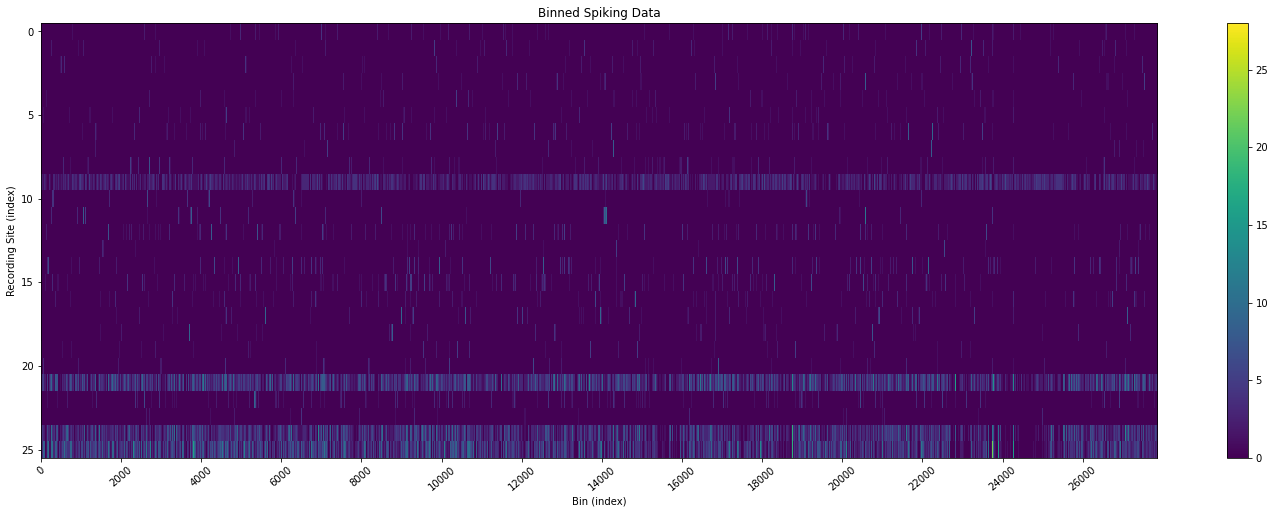

In [ ]:
#@title Visualize Binned Spike Train Data
print(f"Shape of the pruned and binned spike train data:\n\t{pruned_binned_cleaned_spike_data.shape}")
plt.rcParams["figure.figsize"] = (25,8)
plt.title("Binned Spiking Data")
plt.imshow(pruned_binned_cleaned_spike_data, aspect='auto', interpolation='nearest')
plt.xlabel("Bin (index)")
plt.xticks(np.arange(0, len(pruned_binned_cleaned_spike_data[0]), step=2000), rotation=40)
plt.ylabel("Recording Site (index)")
plt.colorbar()
plt.show()

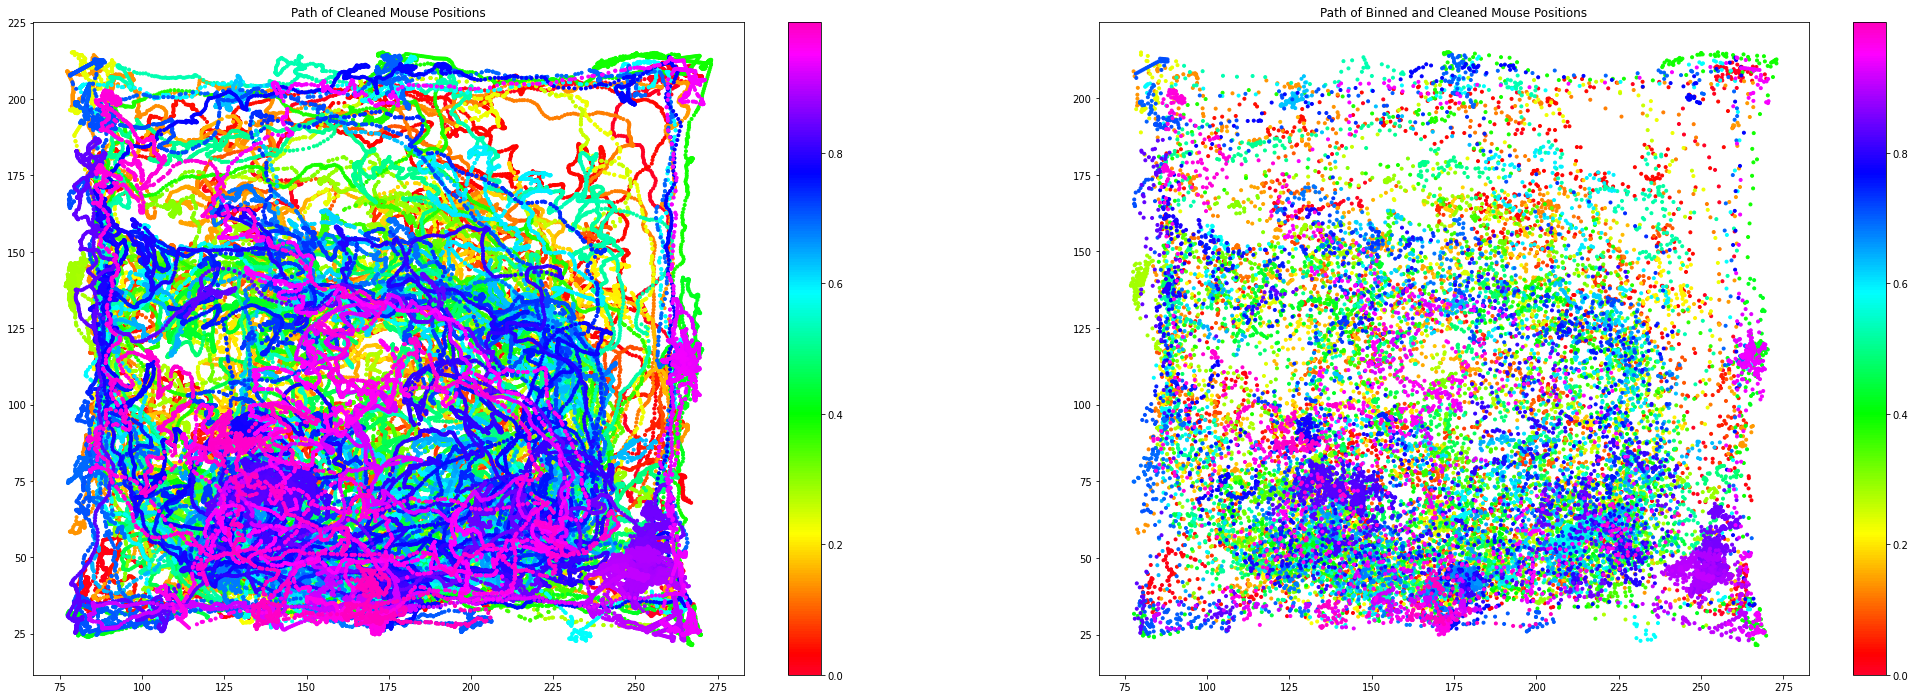

In [ ]:
#@title Plot the Mouse's Raw and Binned Positions
# x_pos = [p[0] for p in cleaned_pos_data]
x_pos = cleaned_pos_data[:, 0]
# y_pos = [p[1] for p in cleaned_pos_data]
y_pos = cleaned_pos_data[:, 1]
colors = np.arange(0, 1, step=1/len(cleaned_pos_data))
plt.rcParams["figure.figsize"] = (35,12)
plt.subplot(1, 2, 1)
# plt.rcParams["figure.figsize"] = (50,9)
plt.title("Path of Cleaned Mouse Positions")

plt.scatter(
    x_pos, 
    y_pos, 
    c=colors, 
    marker='.', 
    cmap='gist_rainbow'
)
plt.colorbar()

binned_cleaned_x_pos = [pos[0] for pos in binned_cleaned_pos_data]
binned_cleaned_y_pos = [pos[1] for pos in binned_cleaned_pos_data]
colors = np.arange(0, 1, step=1/len(binned_cleaned_pos_data))
plt.subplot(1, 2, 2)
plt.title("Path of Binned and Cleaned Mouse Positions")
plt.scatter(
    binned_cleaned_x_pos, 
    binned_cleaned_y_pos, 
    c=colors, 
    marker='.', 
    cmap='gist_rainbow'
)
plt.colorbar()
plt.show()

###Imbalaned Dataset

[TensorFlow Tutorial: Classification on Imbalanced Dataset](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

The output values of our dataset are not balanced unfortunately. 
Imbalanced classes may require stratified sampling to ensure that some classes 
are not overrepresented in different datasets.

Note: In the titles for the histograms that contain the word 'Binned', 
'Binned' in this sense means the average of position samples that fall within 
the same spike data bin.


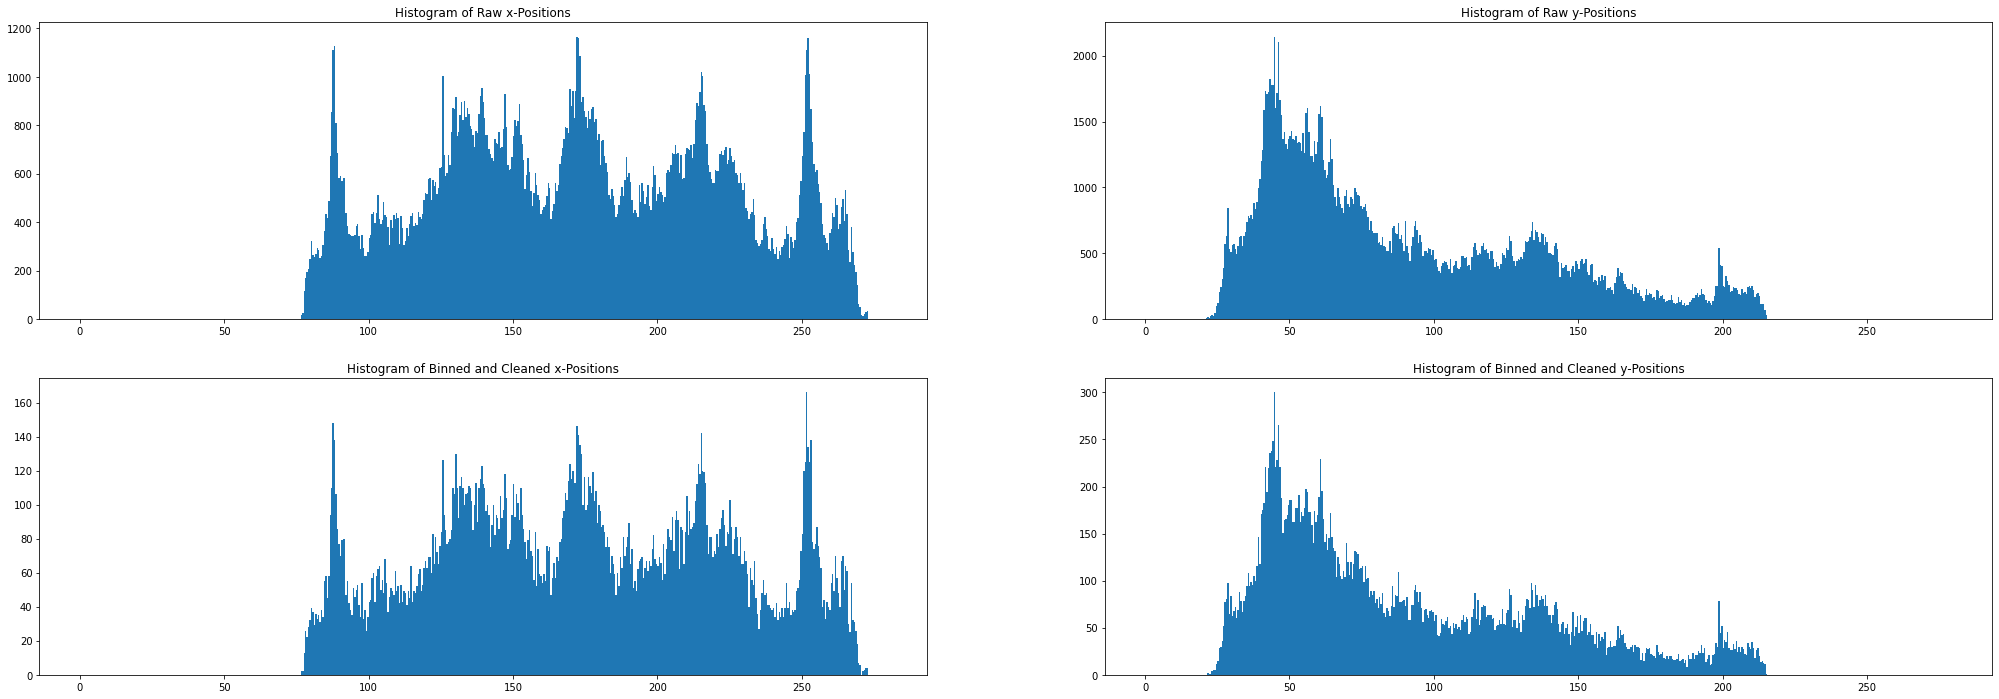

In [ ]:
print("""Note: In the titles for the histograms that contain the word 'Binned', 
'Binned' in this sense means the average of position samples that fall within 
the same spike data bin.""")
bins = np.arange(0, 280, 0.5)
# np.histogram
# the arguments of plt.hist() are passed into np.histogram()
# https://numpy.org/doc/stable/reference/generated/numpy.histogram.html#numpy.histogram
# matplotlib.pyplot.subplot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html#matplotlib.pyplot.subplot
plt.subplot(2, 2, 1)
plt.hist(x_pos, bins=bins)
plt.title("Histogram of Raw x-Positions")
plt.subplot(2, 2, 2)
plt.hist(y_pos, bins=bins)
plt.title("Histogram of Raw y-Positions")
# binned position data
plt.subplot(2, 2, 3)
plt.hist(binned_cleaned_x_pos, bins=bins)
plt.title("Histogram of Binned and Cleaned x-Positions")
plt.subplot(2, 2, 4)
plt.hist(binned_cleaned_y_pos, bins=bins)
plt.title("Histogram of Binned and Cleaned y-Positions")
plt.show()

###Train-Test Split, Stanardize, and Window Data

There are many ways to standrdize the data:
- Only standardize by the recording sites before widnowing.
- Standardize the example features after windowing.

In [ ]:
# @title: Train-Test Split
X = pruned_binned_cleaned_spike_data.transpose()
y = binned_cleaned_pos_data

# num_bins_per_recording_site: the number of time bins after binning the spike 
#   data of the entire hc2 dataset
# num_recording_sites: the number of neurons in the entire hc2 dataset
num_total_bins_per_recording_site, num_recording_sites = X.shape

# num_examples: the number of complete data examples given the number of 
#   pre_bins and post_bins the model will use for inference.
num_examples = num_total_bins_per_recording_site - pre_bins - post_bins

X_matrix = np.zeros((
    num_examples, 
    num_bins_per_recording_site_per_example * num_recording_sites
))
print(f"Shape of the X_matrix:\n\t{X_matrix.shape}")

present_bin_idx = pre_bins
for i in range(num_examples):
    start_idx: int = present_bin_idx - pre_bins
    end_idx: int = present_bin_idx + post_bins + 1
    # i used .flatten() instead of .ravel() because i will be standardizing the
    # dataset and i would like to keep the unstandardized data just in case.
    X_matrix[i, :] = X[start_idx:end_idx, :].flatten()
    present_bin_idx += 1

y = y[pre_bins:-post_bins, :]
assert y.shape[0] == num_examples, f"The number of dataset example labels was expected to be {num_examples}, but was actually {y.shape[0]}."

if randomly_sample_train_test_datasets:
    # note: by performing random sampling liek this, note that i am not 
    # guaranteed to have exactly 80% of my data become training data. i could
    # try to remedy this by moving some examples to achieve this exact split; 
    # however, for large datasets, this is likely negligible.
    train_idx = np.random.default_rng(seed=8177).random(num_examples) < precent_training_data
    test_idx = np.logical_not(train_idx)
else:
    train_test_split_idx_boundary = math.floor(num_examples * precent_training_data)

    train_idx = range(train_test_split_idx_boundary)
    test_idx = range(train_test_split_idx_boundary, num_examples)

# select examples for train dataset
X_train_matrix = X_matrix[train_idx, :]

sklearn_standardization: bool = False
np_standardization: bool = False
if sklearn_standardization:
    # estimate parameters for standardization (0 mean, unit standard deviation) 
    # based on the training dataset performing the train-test split to avoid data
    # leakage.
    scaler = preprocessing.StandardScaler().fit(X_train_matrix)
    X_train_matrix_mean = scaler.mean_
    X_train_matrix_std = scaler.scale_
    print(f"Feature vector mean:\n\t{X_train_matrix_mean}\n")
    print(f"Feature vector standard deviation:\n\t{X_train_matrix_std}\n")
    print(f"Feature vector variance:\n\t{scaler.var_}\n")
    X_train_matrix = scaler.transform(X_train_matrix)
elif np_standardization: 
    X_train_matrix_mean = np.mean(X_train_matrix, axis=0)
    assert X_train_matrix_mean.size == X_train_matrix.shape[1]
    X_train_matrix_std = np.std(X_train_matrix, axis=0)
    assert X_train_matrix_std.size == X_train_matrix.shape[1]
    print(f"Feature vector mean:\n\t{X_train_matrix_mean}\n")
    print(f"Feature vector standard deviation:\n\t{X_train_matrix_std}\n")
    X_train_matrix = (X_train_matrix - X_train_matrix_mean) / X_train_matrix_std

print(f"Shape of X_train_matrix:\n\t{X_train_matrix.shape}")
print("Number of values in X_train_matrix greater than 0:", np.sum(X_train_matrix > 0))
print("Number of values in X_train_matrix less than 0:", np.sum(X_train_matrix < 0))
print("Number of values in X_train_matrix equal to 0:", np.sum(X_train_matrix == 0))
assert np.sum(np.isnan(X_train_matrix)) == 0, f"Expected 0 nan values in X_train_matrix, but there were {np.sum(np.isnan(X_train_matrix))}"

# the order of the axes of the tensor represent (example, binned spike for a bin, recording site)
X_train_tensor = np.reshape(
    X_train_matrix, 
    (X_train_matrix.shape[0], num_bins_per_recording_site_per_example, num_recording_sites)
)
print(f"Shape of X_train_tensor:\n\t{X_train_tensor.shape}")

y_train = y[train_idx, :]
print(f"Shape of y_train:\n\t{y_train.shape}")

# select examples for test dataset
X_test_matrix = X_matrix[test_idx, :]
print(f"Shape of X_test_matrix:\n\t{X_test_matrix.shape}")
# standardize the test covariate samples
if sklearn_standardization or np_standardization:
    X_test_matrix = (X_test_matrix - X_train_matrix_mean) / X_train_matrix_std
print("Number of values in X_test_matrix greater than 0:", np.sum(X_test_matrix > 0))
print("Number of values in X_test_matrix less than 0:", np.sum(X_test_matrix < 0))
print("Number of values in X_test_matrix equal to 0:", np.sum(X_test_matrix == 0))
assert np.sum(np.isnan(X_train_matrix)) == 0, f"Expected 0 nan values in X_test_matrix, but there were {np.sum(np.isnan(X_test_matrix))}"

# the order of the axes of the tensor represent (example, binned spike for a bin, recording site)
X_test_tensor = np.reshape(
    X_test_matrix,
    (X_test_matrix.shape[0], num_bins_per_recording_site_per_example, num_recording_sites)
)
print(f"Shape of X_test_tensor:\n\t{X_test_tensor.shape}")

y_test = y[test_idx, :]
print(f"Shape of y_test:\n\t{y_test.shape}")

num_train_examples, _, _ = X_train_tensor.shape
num_test_examples, _, _ = X_test_tensor.shape
assert num_examples == num_train_examples + num_test_examples, f"The sum of the number of training examples ({num_train_examples}) and test examples ({num_test_examples}) does not equal the number of total training examples ({num_examples})."

Shape of the X_matrix:
	(27847, 234)
Shape of X_train_matrix:
	(22277, 234)
Number of values in X_train_matrix greater than 0: 945188
Number of values in X_train_matrix less than 0: 0
Number of values in X_train_matrix equal to 0: 4267630
Shape of X_train_tensor:
	(22277, 9, 26)
Shape of y_train:
	(22277, 2)
Shape of X_test_matrix:
	(5570, 234)
Number of values in X_test_matrix greater than 0: 202010
Number of values in X_test_matrix less than 0: 0
Number of values in X_test_matrix equal to 0: 1101370
Shape of X_test_tensor:
	(5570, 9, 26)
Shape of y_test:
	(5570, 2)


In [ ]:
def test_matrix_windowing(X: np.ndarray):
    assert len(X.shape) == 2
    n, m = X.shape
    for i in range(1, n):
        prev_idx = np.arange(num_recording_sites, m)
        curr_idx = np.arange(m - num_recording_sites)
        err: str = f"""The overlapping regions of the consecutive data examples
located at indices {i - 1} and {i} are not equivalent. The matrix at {i - 1} was:\n
{X[i - 1, prev_idx]}\n
The matrix at {i} was:\n
{X[i, curr_idx]}"""
        prev_idx = np.arange(num_recording_sites, m)
        curr_idx = np.arange(m - num_recording_sites)
        assert np.asarray(X[i - 1, prev_idx] == X[i, curr_idx]).all(), err
    print("The input matrix passed test_matrix_windowing!")

test_matrix_windowing(X_train_matrix)

def test_tensor_windowing(X: np.ndarray):
    assert len(X.shape) == 3
    n = X.shape[0]
    for i in range(1, n):
        err: str = f"""The overlapping regions of the consecutive data examples
located at indices {i - 1} and {i} are not equivalent. The matrix at {i - 1} was:\n
{X[i - 1, 1:, :]}\n
The matrix at {i} was:\n
{X[i, :-1, :]}"""
        assert np.asarray(X[i - 1, 1:, :] == X[i, :-1, :]).all(), err
    print("The input tensor passed test_tensor_windowing!")

test_tensor_windowing(X_train_tensor)

The input matrix passed test_matrix_windowing!
The input tensor passed test_tensor_windowing!


###Exploratory Data Analysis

Practice some basic statsitical analysis with exploratory data analysis. This would be a good opportunity to apply some unsupervised learning algorithm such as dimensionality reduction (PCA) and clustering. I could also try out some descriptive statistics approaches to attempt to summarize and make sense of this large dataset.

In [ ]:
# compute the sparsity score of the whole dataset
spike_data_sparsity_score = (pruned_binned_cleaned_spike_data.size - np.count_nonzero(pruned_binned_cleaned_spike_data)) / pruned_binned_cleaned_spike_data.size
print(f"Sparsity score (0-1) of the entire binned spike data:\n{spike_data_sparsity_score}\n")
# compute the sparsity score of the data per recording site
spike_sparsity_per_recording_site = (num_total_bins_per_recording_site - np.count_nonzero(pruned_binned_cleaned_spike_data, axis=1)) / num_total_bins_per_recording_site
print(f"Sparsity score (0-1) of binned spike counts per recording site:\n{spike_sparsity_per_recording_site}\n")
# compute the mean of the data per recording site
spike_mean_per_recording_site = np.mean(pruned_binned_cleaned_spike_data, axis=1)
print(f"Mean of binned spike counts per recording site:\n{spike_mean_per_recording_site}\n")
# compute the standard deviation of the data per recording site
spike_std_per_recording_site = np.std(pruned_binned_cleaned_spike_data, axis=1)
print(f"Standard deviation of binned spike counts per recording site:\n{spike_std_per_recording_site}")

Sparsity score (0-1) of the entire binned spike data:
0.8239509548071745

Sparsity score (0-1) of binned spike counts per recording site:
[0.94083647 0.96528451 0.96697182 0.96255609 0.9634895  0.95853527
 0.91057261 0.98560402 0.93570275 0.14413929 0.97996769 0.97224915
 0.90296177 0.98452701 0.91193682 0.90619278 0.93728236 0.95824807
 0.9642075  0.97267995 0.96926943 0.09258661 0.89782804 0.97831628
 0.13430264 0.1264764 ]

Mean of binned spike counts per recording site:
[0.08824269 0.071944   0.05614791 0.06268174 0.05693771 0.06038413
 0.18639383 0.04049542 0.13523604 2.11430623 0.04505475 0.09330461
 0.21321127 0.0366182  0.27905223 0.21331897 0.11125471 0.09718183
 0.07463651 0.05022438 0.0736313  3.54830372 0.21069826 0.04297254
 3.16557171 3.7643511 ]

Standard deviation of binned spike counts per recording site:
[0.40536252 0.46480219 0.36945795 0.38339983 0.34925347 0.34546756
 0.73968084 0.43124767 0.62668379 1.39977239 0.38029249 0.70525125
 0.81492844 0.35903346 1.1025000

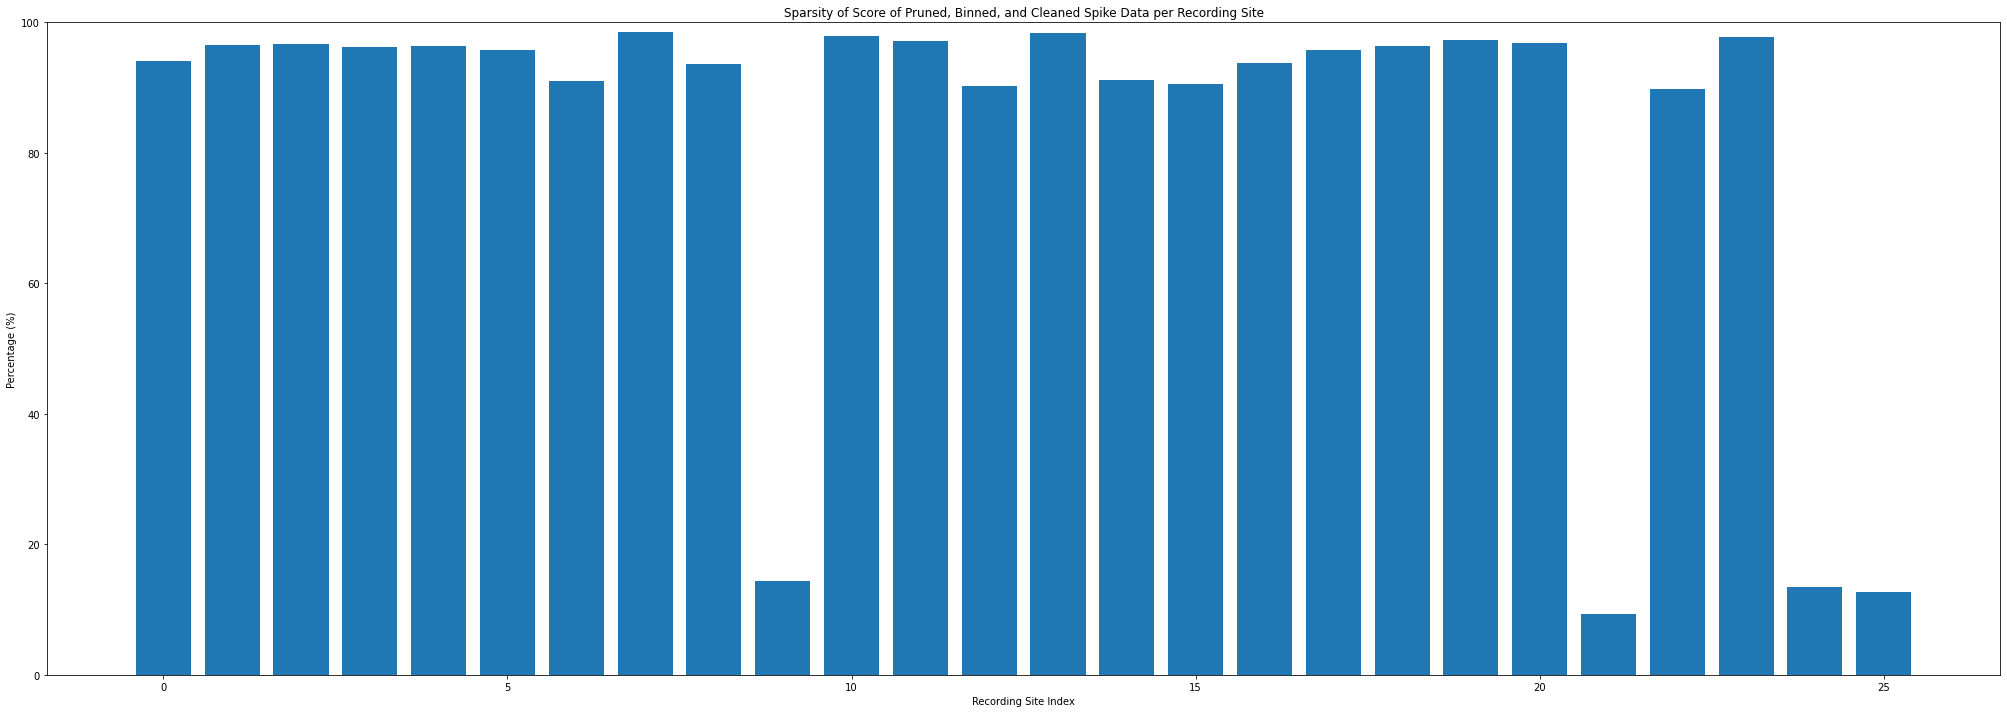

As you can see, most recording sites have a very high sparsity score
meaning that most of our data is 0.

More specifically, 21 out of 26 
recording sites have a sparsity score greater than or equal to 90%.

22 out of 26 recording sites have a 
sparsity score greater than or equal to 80%.

Only 4 out of 26 recording sites have a 
sparsity score less than or equal to 20%.

Clearly, this neural data is quite sparse. The sparsity of the data has posed a 
problem with standardization in that it makes it challenging to divide by the
standrd deviation since it is essentially zero.



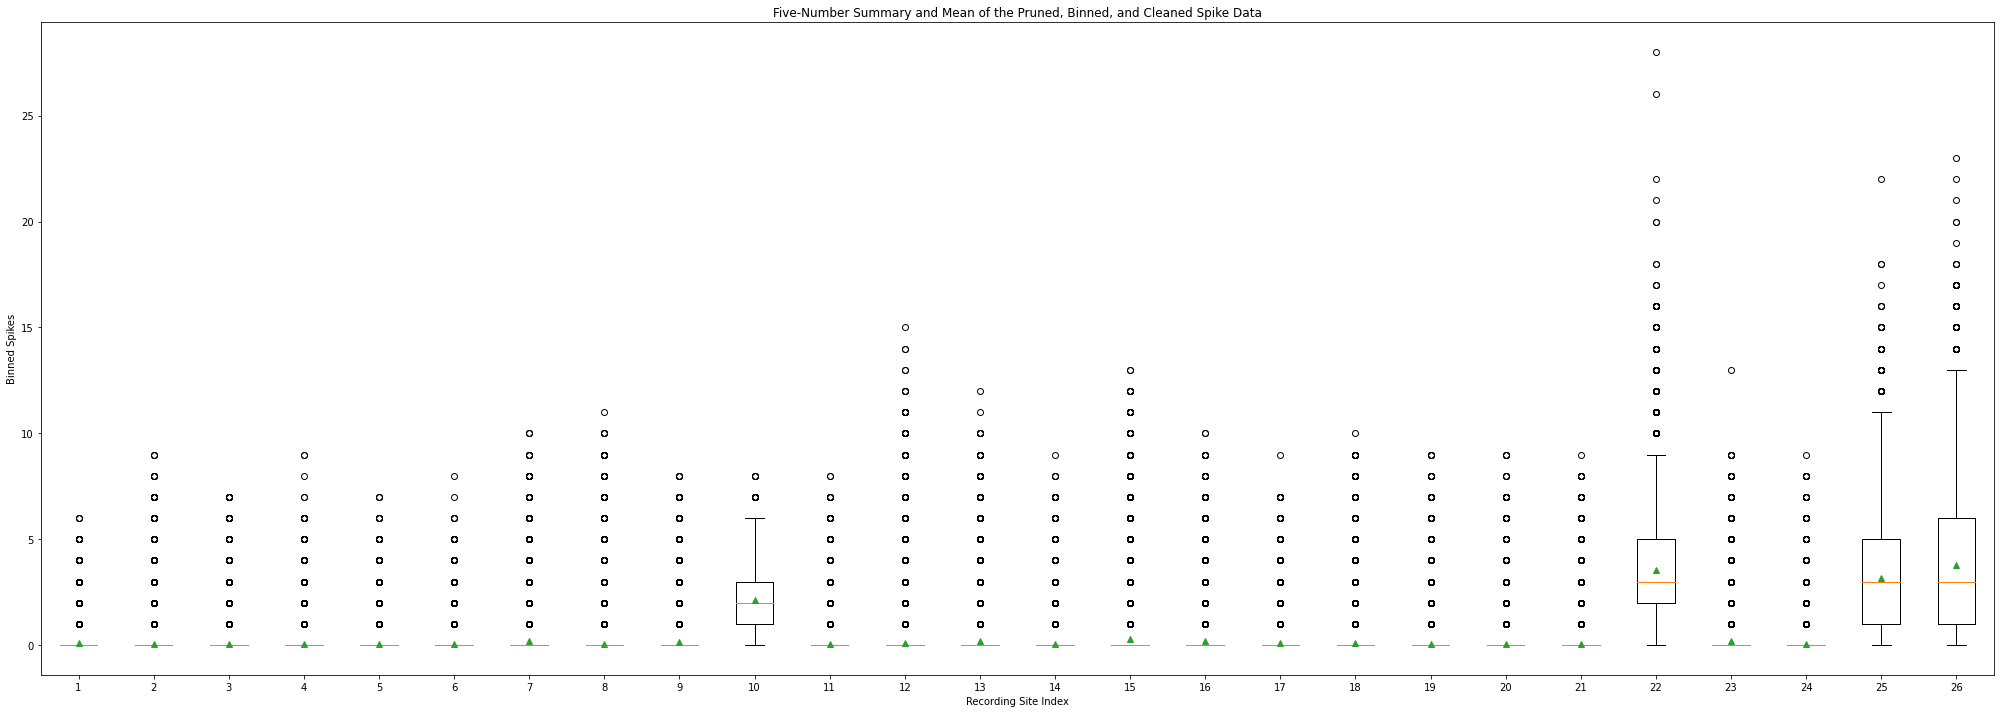

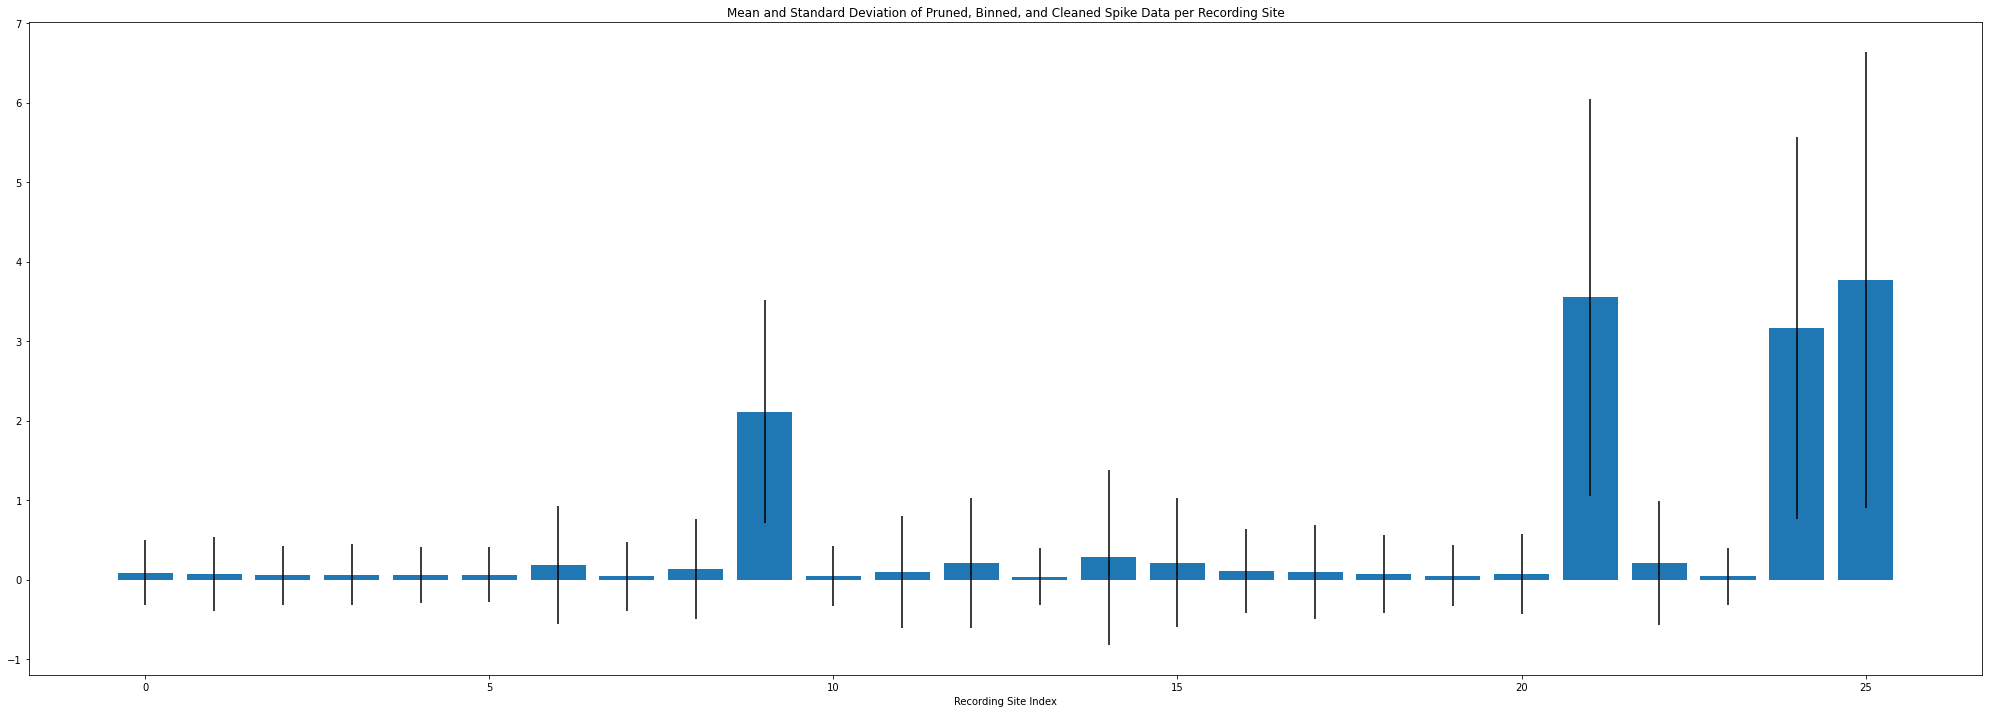

In [ ]:
plt.bar(range(num_recording_sites), spike_sparsity_per_recording_site * 100)
plt.title("Sparsity of Score of Pruned, Binned, and Cleaned Spike Data per Recording Site")
plt.ylim(top=100)
plt.xlabel("Recording Site Index")
plt.ylabel("Percentage (%)")
plt.show()
print(f"""As you can see, most recording sites have a very high sparsity score
meaning that most of our data is 0.

More specifically, {np.sum(spike_sparsity_per_recording_site >= 0.9)} out of {num_recording_sites} 
recording sites have a sparsity score greater than or equal to 90%.

{np.sum(spike_sparsity_per_recording_site >= 0.8)} out of {num_recording_sites} recording sites have a 
sparsity score greater than or equal to 80%.

Only {np.sum(spike_sparsity_per_recording_site <= 0.2)} out of {num_recording_sites} recording sites have a 
sparsity score less than or equal to 20%.

Clearly, this neural data is quite sparse. The sparsity of the data has posed a 
problem with standardization in that it makes it challenging to divide by the
standrd deviation since it is essentially zero.
""")

plt.boxplot(pruned_binned_cleaned_spike_data.transpose(), showmeans=True)
# the five-number summary consists of the 0th, 1st, 2nd, 3rd, and 4th quartiles 
# of the data
plt.title("Five-Number Summary and Mean of the Pruned, Binned, and Cleaned Spike Data")
plt.xlabel("Recording Site Index")
plt.ylabel("Binned Spikes")
plt.show()

plt.bar(range(num_recording_sites), spike_mean_per_recording_site, yerr=spike_std_per_recording_site)
plt.title("Mean and Standard Deviation of Pruned, Binned, and Cleaned Spike Data per Recording Site")
plt.xlabel("Recording Site Index")
plt.show("Binned Spikes")

# TODO: compute the range of the data
# TODO: do anomaly or outlier detection

In [ ]:
# compute the mean of the data per recording site
spike_mean_per_feature = np.mean(X_matrix, axis=0)
# np.set_printoptions(threshold=sys.maxsize)
print(f"Mean of binned spike counts per feature:\n{spike_mean_per_feature}\n")
# compute the standard deviation of the data per recording site
spike_std_per_feature = np.std(X_matrix, axis=0)
print(f"Standard deviation of binned spike counts per feature:\n{spike_std_per_feature}")

Mean of binned spike counts per feature:
[0.08826804 0.07196466 0.05616404 0.06269975 0.05695407 0.06040148
 0.18637555 0.04050706 0.13527489 2.1144468  0.04506769 0.09333142
 0.21327252 0.03662872 0.2791324  0.21338026 0.11128667 0.09720975
 0.07465795 0.0502388  0.07365246 3.5486767  0.21075879 0.04298488
 3.16561928 3.76442705 0.08826804 0.07196466 0.05616404 0.06269975
 0.05695407 0.06040148 0.18637555 0.04050706 0.13527489 2.11455453
 0.04506769 0.09333142 0.21327252 0.03662872 0.2791324  0.21338026
 0.11128667 0.09720975 0.07465795 0.0502388  0.07365246 3.54871261
 0.21075879 0.04298488 3.16554746 3.76406794 0.08826804 0.07192875
 0.05616404 0.06269975 0.05695407 0.06040148 0.18637555 0.04050706
 0.13527489 2.11466226 0.04506769 0.09333142 0.21327252 0.03662872
 0.2791324  0.21338026 0.11128667 0.09720975 0.07462204 0.0502388
 0.07365246 3.54874852 0.21075879 0.04298488 3.16558337 3.76367293
 0.08826804 0.07182102 0.05616404 0.06269975 0.05695407 0.06040148
 0.18637555 0.04047115

##Machine Learning for Neural Decoding

I can also do random sampling now on the data examples by created a random vector and associating the index in the random vector with an index in X_tensor/_matrix and move the example into train or test based on if the random numebr is less than the percent_training_data. However, one problem with this is that I cannot apply the fix that I previously did

In [ ]:
from sklearn import linear_model
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, KFold

from matplotlib import pyplot as plt

def graph_preds_vs_truth(y_true: np.ndarray, y_pred: np.ndarray, title: str):
    """
    plots the predicted value of the dependent variable vs the ground truth 
    value of the dependent variable.
    """
    plt.rcParams["figure.figsize"] = (25,8)
    plt.title(title)
    plt.plot(y_true)
    plt.plot(y_pred)
    plt.legend(["True Labels", "Predicted Lables"])
    plt.show()

def trace_pred_vs_true_paths(y_true: np.ndarray, y_pred: np.ndarray, title: str):
    """
    plots the predicted mouse's path vs the ground truth mouse path.
    It would also be cool if this were animated to help elucidate which pairs of
    predicted and true labels are associated with one another.
    """
    pass

r2_scorer = make_scorer(r2_score)

###Neural Decoder ML Model Validation

First, I will use k-fold cross-validation for model selection and hyperparameter tuning among the followng machine learning algorithms to select an optimal learning algorithm configuration for training and evaluation:

- Linear Regression
- Ridge Regression
- LASSO Regression
- Support Vector Regression
- Artificial Neural Network

In [ ]:
# map of machine learning algorithm name to tuple of score and hyperparameters
all_models_val_score = {}

####Linear Regression

The Wiener filter is a type of linear regression; however, the implementation that I referenced is far more complicated than a traditional linear regression. On top of that the Wiener filter assuems that the random process is wide-sense stationary (the expectation and correlation is constant across time lags), so onlt a small subset fo the data is used for training (i.e. the same amount of data necessary to compute the Wiener filter). This same filter is then applied at every prediction.

A traditional linear regression could be fit on more than the amount of data ncessary to make a prediction. Consequently, the linear regression may perform better on a larger amount of data.

[Learning to Control a Brain–Machine Interface for Reaching and Grasping by Primates](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC261882/): This paper discusses using linear regression for neural decoding of neural data.

[scikit-learn linear regression example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#linear-regression-example)

Linear Regression on Sparse Matrices:
- [stackoverflow](https://stackoverflow.com/questions/68244768/python-linear-regression-dense-vs-sparse)
- [stackexchange](https://stats.stackexchange.com/questions/215308/linear-regression-on-large-sparse-feature-set)
- [NYU Sparse Regression](https://cims.nyu.edu/~cfgranda/pages/OBDA_spring16/material/sparse_regression.pdf)
- [Sparse regression for large data sets with outliers](https://www.sciencedirect.com/science/article/pii/S037722172100477X)

In [ ]:
# sklearn.linear_model.LinearRegression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# linear regression example
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#linear-regression-example
linear_regressor = linear_model.LinearRegression()

# sklearn.model_selection.KFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
cv = KFold(n_splits=10, shuffle=False)
scores = cross_validate(
    estimator=linear_regressor, 
    X=X_train_matrix, 
    y=y_train, 
    scoring=r2_scorer, 
    cv=cv,
    return_estimator=True
)

print(scores["estimator"])

linear_regression_val_score = np.mean(scores["test_score"])
all_models_val_score["linear_regression"] = (linear_regression_val_score, None)

print(f"The coefficient of determination (R^2 score) from cross-validation on the X_train_matrix dataset for linear regression:\n\t{linear_regression_val_score}")

# my attempt at averaging the parameters across the regressors produced by cross-
# validation so that I could have an idea of how well it performed by graphing the
# predictions of the averaged coefficients.
# avg_params_val_linear_regression = np.mean(np.asarray([np.concatenate((e.coef_, e.intercept_), axis=0) for e in scores["estimator"]]), axis=0)
# print(avg_params_val_linear_regression)
# linear_regressor.coef_ = avg_params_val_linear_regression[:, :-1]
# linear_regressor.intercept_ = avg_params_val_linear_regression[:, -1:]
# print(f"Estimated y-interecpt of the linear regression:\n\t{linear_regressor.intercept_}")
# print(f"Estimated weights estimated of the linear regression:\n{linear_regressor.coef_}\n")
# y_pred = linear_regressor.predict(X_train_matrix)
# graph_preds_vs_truth(y_train[:, 0], y_pred[:, 0], "Linear Regression: X-Position Predictions vs Ground Truth")
# graph_preds_vs_truth(y_train[:, 1], y_pred[:, 1], "Linear Regression: Y-Position Predictions vs Ground Truth")

[LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression()]
The coefficient of determination (R^2 score) from cross-validation on the X_train_matrix dataset for linear regression:
	0.30441673411556536


####LASSO Regression

The coefficient of determination (R^2 score) from cross-validation on the X_train_matrix dataset for LASSO regression:
	0.3052769805986533
The optimal hyperparameters for LASSO regression evaluated with cross-validation on the X_train_matrix dataset:
	{'alpha': 0.1}


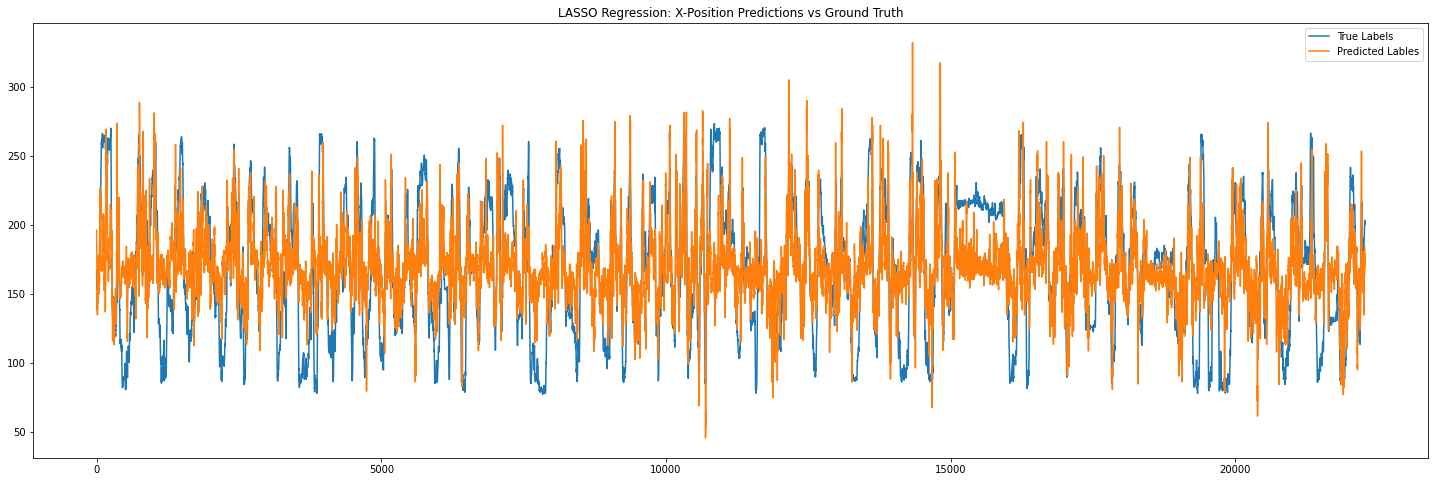

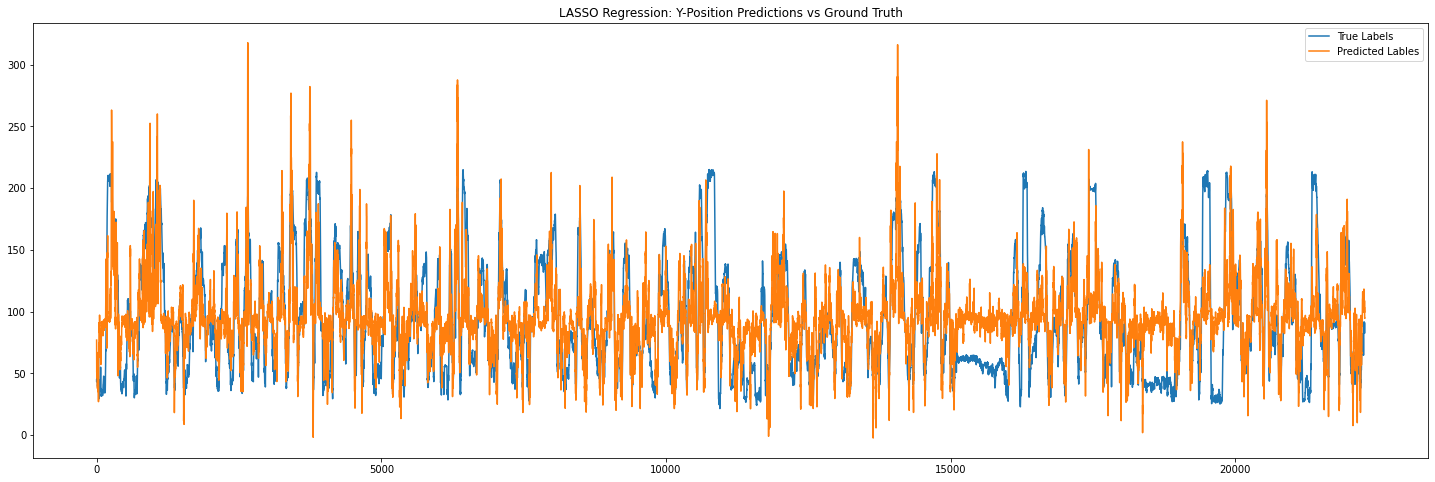

In [ ]:
# sklearn.linear_model.Lasso
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso
lasso_regressor = linear_model.Lasso()

# sklearn.model_selection.KFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
param_grid = {"alpha": [1e-2, 0.5e-1, 1e-1, 0.5, 1, 0.5e1, 1e1, 0.5e2, 1e2, 0.5e3, 1e3]}
grid_search_cross_validator = GridSearchCV(estimator=lasso_regressor, param_grid=param_grid, scoring=r2_scorer, cv=10)
grid_search_cross_validator.fit(X=X_train_matrix, y=y_train)

# .best_score_ contains the mean cross-validated score of the best_estimator
lasso_regression_val_score = grid_search_cross_validator.best_score_
lasso_regression_val_estimator = grid_search_cross_validator.best_estimator_
all_models_val_score["lasso_regression"] = (linear_regression_val_score, grid_search_cross_validator.best_params_)

print(f"The coefficient of determination (R^2 score) from cross-validation on the X_train_matrix dataset for LASSO regression:\n\t{lasso_regression_val_score}")
print(f"The optimal hyperparameters for LASSO regression evaluated with cross-validation on the X_train_matrix dataset:\n\t{grid_search_cross_validator.best_params_}")

y_pred = lasso_regression_val_estimator.predict(X_train_matrix)
graph_preds_vs_truth(y_train[:, 0], y_pred[:, 0], "LASSO Regression: X-Position Predictions vs Ground Truth")
graph_preds_vs_truth(y_train[:, 1], y_pred[:, 1], "LASSO Regression: Y-Position Predictions vs Ground Truth")

####Ridge Regression

The coefficient of determination (R^2 score) from cross-validation on the X_train_matrix dataset for Ridge regression:
	0.30529114113385186
The optimal hyperparameters for Ridge regression evaluated with cross-validation on the X_train_matrix dataset:
	{'alpha': 1000.0}


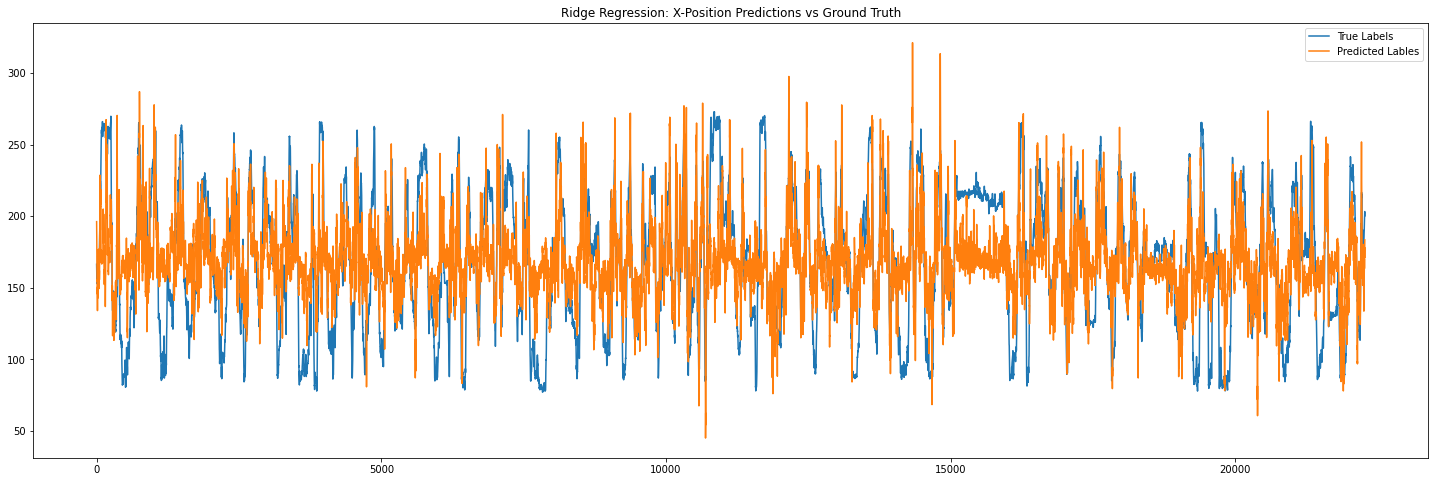

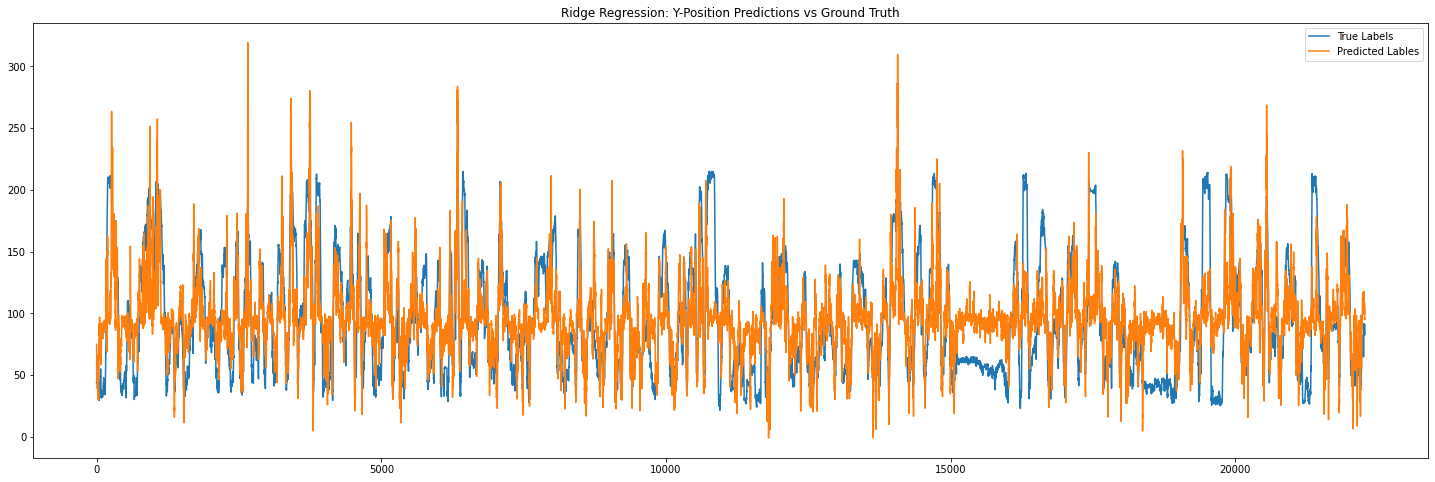

In [ ]:
# sklearn.linear_model.Ridge
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
ridge_regressor = linear_model.Ridge()

# sklearn.model_selection.KFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
param_grid = {"alpha": [1e-2, 0.5e-1, 1e-1, 0.5, 1, 0.5e1, 1e1, 0.5e2, 1e2, 0.5e3, 1e3]}
grid_search_cross_validator = GridSearchCV(estimator=ridge_regressor, param_grid=param_grid, scoring=r2_scorer, cv=10)
grid_search_cross_validator.fit(X=X_train_matrix, y=y_train)

# .best_score_ contains the mean cross-validated score of the best_estimator
ridge_regression_val_score = grid_search_cross_validator.best_score_
ridge_regression_val_estimator = grid_search_cross_validator.best_estimator_
all_models_val_score["ridge_regression"] = (ridge_regression_val_score, grid_search_cross_validator.best_params_)

print(f"The coefficient of determination (R^2 score) from cross-validation on the X_train_matrix dataset for Ridge regression:\n\t{ridge_regression_val_score}")
print(f"The optimal hyperparameters for Ridge regression evaluated with cross-validation on the X_train_matrix dataset:\n\t{grid_search_cross_validator.best_params_}")

y_pred = ridge_regression_val_estimator.predict(X_train_matrix)
graph_preds_vs_truth(y_train[:, 0], y_pred[:, 0], "Ridge Regression: X-Position Predictions vs Ground Truth")
graph_preds_vs_truth(y_train[:, 1], y_pred[:, 1], "Ridge Regression: Y-Position Predictions vs Ground Truth")

In [ ]:
print(all_models_val_score)

{'linear_regression': (0.30441673411556536, None), 'lasso_regression': (0.30441673411556536, {'alpha': 0.1}), 'ridge_regression': (0.30529114113385186, {'alpha': 1000.0})}


####Support Vector Machines

####Artificial Neural Network

Make sure to standardize the dataset.

Try using state of the art methods that tend to improve the performance of base models such as drop out, batch normalization, and layer normalization (to normalize the values passed in between layers).

I may also want to test out methods in Neural Architecture Search.

###Neural Decoder ML Model Training

Through nested cross-validation the final model configuration was selected to be: 

####This model with these hyperparameters

####Baseline Model

I should use a simple heuristic to predict the label to act as a baseline model. I expect any models that are more cmoplex learners to perform at least as well as the baseline model.

[Google Machine Learning Education: Foundational Courses: Testing and Debugging Model Debugging](https://developers.google.com/machine-learning/testing-debugging/common/model-errors)

####Ensemble Methods

###Neural Decoder ML Model Evaluation

Select the best metric for evaluating the performance of the final model. I may also want to try evaluating peroformance based on infernece performance metrics.

##Bibliography

- [Mizuseki K, Sirota A, Pastalkova E, Buzsáki G. (2009): Multi-unit recordings from the rat hippocampus made during open field foraging.](http://dx.doi.org/10.6080/K0Z60KZ9)
- [Neuralink: An integrated brain-machine interface platform with thousands of channels](https://www.biorxiv.org/content/10.1101/703801v4.full)
- [Neuralink: Approach](https://neuralink.com/approach/)
- [TensorFlow: Time Series Forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series#normalize_the_data)